### Import required libraries

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN, MNIST
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from typing import Type, List
import torch.optim as optim
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize, RandomApply, ColorJitter, RandomRotation

In [4]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [5]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

In [6]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, classes, smoothing=0.25, dim=-1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

### Base transformation - DataAug

In [7]:
transform_svhn = Compose([
    RandomApply([ColorJitter(brightness=0.5, contrast=0.5)], p=0.3),
    RandomRotation(degrees=15),
    ToTensor(),
    Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1201, 0.1231, 0.1052])
])


transform_mnist = Compose([
    Resize((32,32)),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3015, 0.3015, 0.3015])
])

,### loading the Datasets

In [8]:
train_dataset_svhn = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
test_dataset_svhn = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

train_loader_svhn = DataLoader(dataset=train_dataset_svhn, batch_size=16, shuffle=True, num_workers=2)
test_loader_svhn = DataLoader(dataset=test_dataset_svhn, batch_size=16, shuffle=False, num_workers=2)

train_dataset_mnist = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=16, shuffle=True, num_workers=2)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=16, shuffle=False, num_workers=2)

print("Data loaders have been created.")

100%|██████████| 182040794/182040794 [00:05<00:00, 32996170.91it/s]


100%|██████████| 64275384/64275384 [00:01<00:00, 32409381.00it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 142467467.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35450890.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43971003.84it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5093724.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data loaders have been created.


###  Initialize the Model, Loss Function, and Optimizer### Define Metrics

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = LabelSmoothingCrossEntropy(classes=10)

### Training definition

In [11]:
num_epochs = 10
losses = []

for epoch in tqdm(range(num_epochs), desc='Training Epochs'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_svhn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader_svhn)
    losses.append(epoch_loss)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {100.*correct/total:.2f}%')

Training Epochs:  10%|█         | 1/10 [01:40<15:06, 100.74s/it]

Epoch 1/10, Training Loss: 1.6149, Training Accuracy: 69.87%


Training Epochs:  20%|██        | 2/10 [03:18<13:13, 99.15s/it] 

Epoch 2/10, Training Loss: 1.3749, Training Accuracy: 84.83%


Training Epochs:  30%|███       | 3/10 [04:58<11:36, 99.56s/it]

Epoch 3/10, Training Loss: 1.3323, Training Accuracy: 87.15%


Training Epochs:  40%|████      | 4/10 [06:37<09:56, 99.38s/it]

Epoch 4/10, Training Loss: 1.2935, Training Accuracy: 89.35%


Training Epochs:  50%|█████     | 5/10 [08:16<08:15, 99.03s/it]

Epoch 5/10, Training Loss: 1.2822, Training Accuracy: 89.88%


Training Epochs:  60%|██████    | 6/10 [09:54<06:34, 98.70s/it]

Epoch 6/10, Training Loss: 1.2650, Training Accuracy: 90.93%


Training Epochs:  70%|███████   | 7/10 [11:33<04:56, 98.79s/it]

Epoch 7/10, Training Loss: 1.2566, Training Accuracy: 91.37%


Training Epochs:  80%|████████  | 8/10 [13:11<03:17, 98.55s/it]

Epoch 8/10, Training Loss: 1.2492, Training Accuracy: 91.88%


Training Epochs:  90%|█████████ | 9/10 [14:50<01:38, 98.58s/it]

Epoch 9/10, Training Loss: 1.2394, Training Accuracy: 92.44%


Training Epochs: 100%|██████████| 10/10 [16:30<00:00, 99.08s/it]

Epoch 10/10, Training Loss: 1.2312, Training Accuracy: 92.94%


### plotting the loss

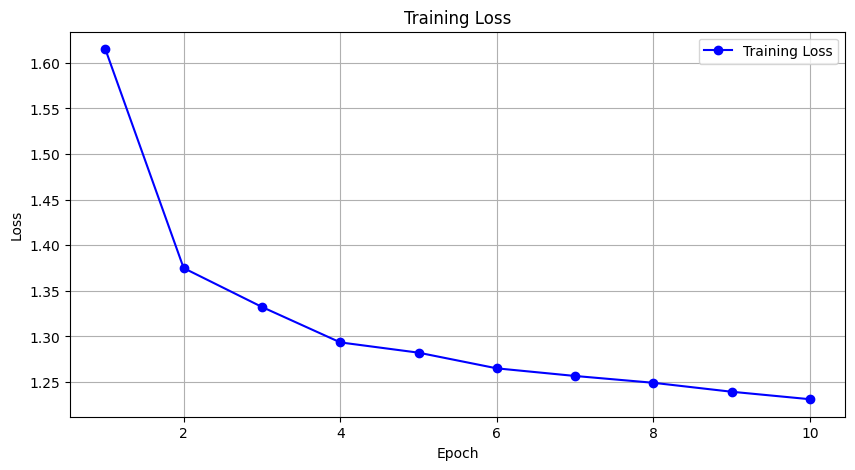

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Testing the model

In [13]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

### Results

In [14]:
accuracy_svhn = test_model(model, test_loader_svhn)
accuracy_mnist = test_model(model, test_loader_mnist)

Accuracy: 91.96%
Accuracy: 78.54%
